<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [22]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
def objective(x, noise=0.1):
    noise = np.random.normal(loc=0, scale=noise)
    return -(x**2 * np.sin(5 * np.pi * x)**6.0) + noise

Optima: x=0.900, y=-0.810


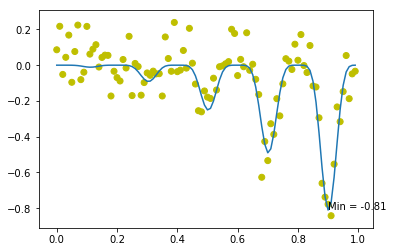

In [25]:
# Sample the domain of the objective function
X = np.arange(0, 1, 0.01)

# Sample the domain without noise
y = [objective(x, noise=0) for x in X]

# Sample the domain with noise
ynoise = [objective(x, noise=0.1) for x in X]

# Actual max value usually not known for model
ix = np.argmin(y)
print('Optima: x=%.3f, y=%.3f' % (X[ix], y[ix]))

plt.plot(X, y, label='W/o noise')
plt.scatter(X, ynoise, color='yy', label='W/ noise')
plt.annotate(f'Min = {y[ix]:.2f}', [X[ix], y[ix]])
plt.show()

In [26]:
from warnings import catch_warnings
from warnings import simplefilter
from sklearn.gaussian_process import GaussianProcessRegressor

# Surrogate or approximation for the objective function
def surrogate(model, X):
    # Catch any warning generated when making a prediction
    with catch_warnings():
        # Ignore generated warnings
        simplefilter("ignore")
        return model.predict(X, return_std=True)
    
# Plot real observations vs surrogate function
def plotGP(X, y, model):
    # Scatter plot of inputs and real objective function
    plt.scatter(X, y)
    
    # Line plot of surrogate function across domain
    Xsamples = np.arange(0, 1, 0.001)
    Xsamples = Xsamples.reshape(len(Xsamples), 1)
    ysamples, _ = surrogate(model, Xsamples)
    plt.plot(Xsamples, ysamples)
    plt.show()

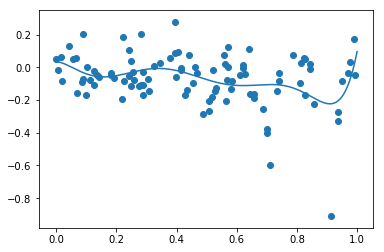

In [27]:
# Sample the domain sparsely with noise
X = np.random.random(100)
y = np.asarray([objective(x) for x in X]) # w/ noise

# Reshape into rows and cols
X = X.reshape(len(X), 1)
y = y.reshape(len(y), 1)

# Define the model
model = GaussianProcessRegressor()

# Fit the model
model.fit(X, y)

# Plot the surrogate function
plotGP(X, y, model)

In [30]:
from scipy.stats import norm

# Optimize the acquisition function
def opt_acquisition(X, y, model):
    # Random search, generate random samples
    Xsamples = np.random.random(100)
    Xsamples = Xsamples.reshape(len(Xsamples), 1)
    
    # Calculate the acquisition function for each sample
    scores = acquisition(X, Xsamples, model)
    
    # Locate the index of the largest scores
    ix = np.argmax(scores)
    return Xsamples[ix, 0]


# Probability of improvement acquisition function
def acquisition(X, Xsamples, model):
    # Calculate the best surrogate score found so far
    yhat, _ = surrogate(model, X)
    best = min(yhat)
    
    # Calculate mean and stdev via surrogate function
    mu, std = surrogate(model, Xsamples)

    # Calculate the probability of improvement
    probs = norm.cdf((best - mu[:,0]) / (std+1E-9))
    return probs

>x=0.914, f()=-0.692824, actual=-0.732
>x=0.911, f()=-0.696051, actual=-0.802
>x=0.910, f()=-0.696574, actual=-0.859
>x=0.901, f()=-0.693464, actual=-0.805
>x=0.914, f()=-0.693819, actual=-0.790
>x=0.096, f()=-0.045650, actual=-0.088
>x=0.309, f()=0.005179, actual=-0.000
>x=0.893, f()=-0.680910, actual=-0.693
>x=0.218, f()=-0.034908, actual=0.081
>x=0.917, f()=-0.690554, actual=-0.630
>x=0.910, f()=-0.697377, actual=-0.750
>x=0.907, f()=-0.698160, actual=-0.828
>x=0.886, f()=-0.662498, actual=-0.643
>x=0.927, f()=-0.660803, actual=-0.521
>x=0.897, f()=-0.689060, actual=-0.675
>x=0.908, f()=-0.698162, actual=-0.868
>x=0.901, f()=-0.695480, actual=-0.651
>x=0.937, f()=-0.606817, actual=-0.141
>x=0.909, f()=-0.697405, actual=-0.686
>x=0.904, f()=-0.696948, actual=-0.877
>x=0.917, f()=-0.688322, actual=-0.640
>x=0.886, f()=-0.664451, actual=-0.666
>x=0.920, f()=-0.682966, actual=-0.676
>x=0.895, f()=-0.685903, actual=-0.634
>x=0.911, f()=-0.696732, actual=-0.722
>x=0.903, f()=-0.696393, ac

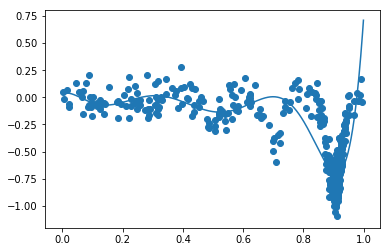

Best Result: x=0.911, y=-1.098


In [39]:
# Verification of bayesian optimization working
est_values = []
actual_values = []

# Perform the optimization process
for i in range(100):
    # Select the next point to sample
    x = opt_acquisition(X, y, model)
    
    # Sample the point
    actual = objective(x)

    # Summarize the finding for our own reporting
    est, _ = surrogate(model, [[x]])
    print('>x=%.3f, f()=%3f, actual=%.3f' % (x, est, actual))
    
    est_values.append(est[0,0])
    actual_values.append(actual)
    
    # Add the data to the dataset
    X = np.vstack((X, [[x]]))
    y = np.vstack((y, [[actual]]))
    
    # Update the model
    model.fit(X, y)
    
# Plot all samples and the final surrogate function
plotGP(X, y, model)

# Best result
ix = np.argmin(y)
print('Best Result: x=%.3f, y=%.3f' % (X[ix], y[ix]))

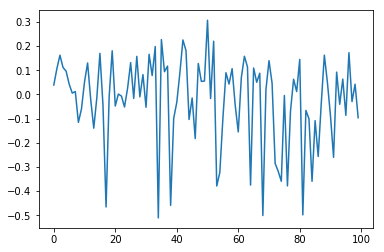

In [40]:
plt.plot(np.asarray(est_values)-np.asarray(actual_values))

# Ideally, the difference between the estimated value and the actual value 
# should be getting smaller and smaller as the model fitting improves

In [47]:
from numpy import mean
from sklearn.datasets import make_blobs
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from skopt.space import Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

# Generate 2d classification dataset
X, y = make_blobs(n_samples=500, centers=3, n_features=2)

# Define the model
model = KNeighborsClassifier()

# Define the space of hyperparameters to search
search_space = [Integer(1, 5, name='n_neighbors'), Integer(1, 2, name='p')]

# Define the function used to evaluate a given configuration
@use_named_args(search_space)
def evaluate_model(**params):
    # something
    model.set_params(**params)
    
    # calculate 5-fold cross validation
    result = cross_val_score(model, X, y, cv=5, n_jobs=-1, scoring='accuracy')
    
    # calculate the mean of the scores
    estimate = mean(result)
    
    return 1.0 - estimate

# perform optimization
result = gp_minimize(evaluate_model, search_space, n_calls=35)

# summarizing finding:
print('Best Accuracy: %.3f' % (1.0 - result.fun))
print('Best Parameters: n_neighbors=%d, p=%d' % (result.x[0], result.x[1]))

/Users/achar/miniconda3/envs/py36/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/achar/miniconda3/envs/py36/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/achar/miniconda3/envs/py36/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/achar/miniconda3/envs/py36/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/achar/miniconda3/envs/py36/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been eval

Best Accuracy: 1.000
Best Parameters: n_neighbors=3, p=2
